# evaluate ekman pumping in easterlies experiment

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:38125' processes=4 threads=8, memory=200.00 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [5]:
ee = explore.ExperimentExplorer(session=master_session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [6]:
expt = '01deg_jra55v13_ryf9091'
variable='geolat_c'
geolat_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_c.load()
print(geolat_c.shape)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
yt_ocean.load()
print(yt_ocean.shape)

variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

(2700, 3600)
(2700,)
(3600,)
(2700, 3600)


In [7]:
#Calculate coriolis param

# these are the values used by MOM5
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

f = 2 * Ω * np.sin(np.deg2rad(geolat_c)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'
print(f.shape)

(2700, 3600)


In [11]:
# simulations:
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down= '01deg_jra55v13_ryf9091_easterlies_down10'

In [12]:
# 15years of simulation:
start_time='2150-01-01'
#end_time='2164-12-31'
end_time='2150-12-31'

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-50.04) #-50.04-

In [13]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

## Prepare dx and dy

In [14]:
# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.
# Navid this is a fix that needs to be applied to your method 2
tau_x = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)

In [15]:
dyu['ni'] = tau_x['xu_ocean'].values
dyu['nj'] = tau_x['yu_ocean'].values
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))

In [16]:
dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x['xu_ocean'].values
dxu['nj'] = tau_x['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))

In [17]:
# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

## Global Control Ekman pumping calc ... method 2
### based on method 2 from https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
### First do 1 year global to compare to Figure 3 here
### https://www.sciencedirect.com/science/article/pii/S1463500318303779?via%3Dihub




In [15]:
#just do 1 year global to compare to obs
end_time='2150-12-31'
tau_x = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time))
tau_x = tau_x.load()

tau_y = cc.querying.getvar(control, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time))
tau_y = tau_y.load()

In [16]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives: note expecting a time dim
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:  note expecting a time dim
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [17]:
ekman = curl_tauf.mean(dim='time')/rho0*s_day
# mask land:
ekman = ekman.where(ekman!=0)

In [18]:
# Change coords to t grid:
ekman['xu_ocean'] = xt_ocean.values
ekman['yu_ocean'] = yt_ocean.values
ekman = ekman.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

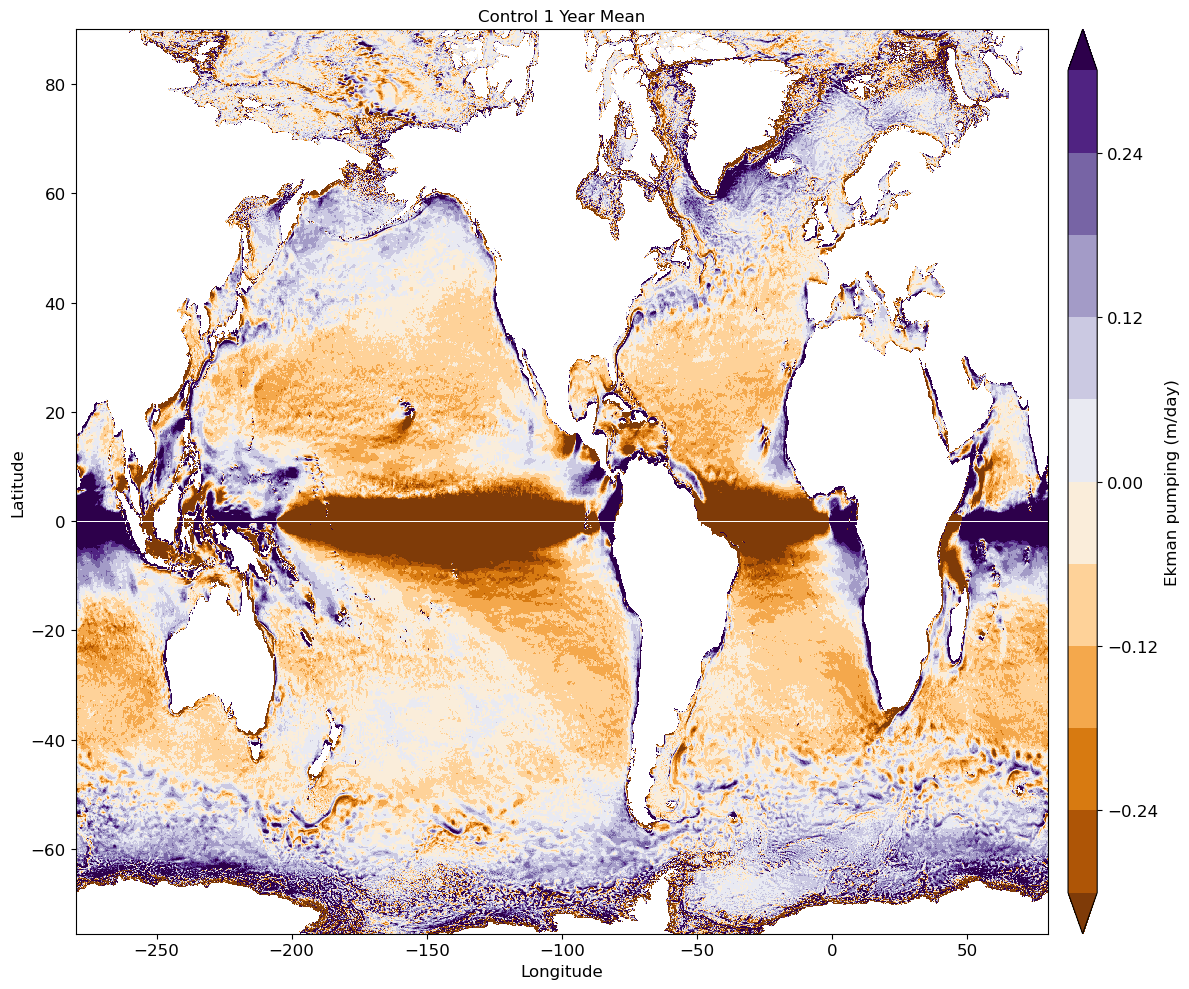

In [19]:
#ekman.mean(dim='time').plot.pcolormesh(cmap=cmocean.balance,vmin=-.3,vmax=.3)

#Compare to Figure 3 in this paper
#https://www.sciencedirect.com/science/article/pii/S1463500318303779?via%3Dihub

fontsize=12

clev = np.arange(-.30,.36,.06)

plt.figure(figsize=(12,10))

plt.subplot(1,1,1)
pc=ekman.plot.pcolormesh(x='xt_ocean', y='yt_ocean',vmin=-.30, vmax=.30, levels=clev,cmap=plt.cm.PuOr,add_colorbar=False)
plt.ylim(-75.5,90)
plt.xlim(-280,80)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.title('Control 1 Year Mean',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

# smooth global Ekman pumping to 1 deg grid

In [20]:
#regrid to smooth
#https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html#gallery-documented-examples-regridding-ipynb
grid010 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})


In [21]:
ekman = ekman.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
ekman = ekman.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                          'geolon_t': 'lon', 'geolat_t': 'lat'})


In [22]:
#1 degx1deg grid
ds_out = xesmf.util.grid_global(1, 1)
ds_out = ds_out.drop({'lon_b', 'lat_b'})

# let's shift our longitude grid so that it spans [-280, 80] instead [-180, 180]
# this is just for plotting purposes so that the seam is in the Indian Ocean
# rather than in the middle of the Pacific Ocean
ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})

#ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, y: 180)
Coordinates:
    lon      (y, x) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: x, y
Data variables:
    *empty*

In [23]:
#ekman = ekman.rename({'longitude': 'lon', 'latitude':'lat'})
ekman

<xarray.DataArray (y: 2700, x: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x         (x) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * y         (y) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
    geolon_c  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    geolat_c  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    TLON      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    TLAT      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ULON      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ULAT      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat       (y, x) float64 ...
    lon       (y, x) float64 ...

In [24]:
wf='bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc'
#wf='bilinear_tracer_weights_in010degACCESSOM2_out5deg.nc'
ds_in_010deg = ekman.drop({'x', 'y'})

regridder_010degACCESSOM2_1deg = xesmf.Regridder(ds_in_010deg, ds_out, 'bilinear', periodic=True,
                                                 filename=wf,reuse_weights=os.path.exists('wf'))
regridder_010degACCESSOM2_1deg

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (2700, 3600) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [25]:
ekman_regridded = regridder_010degACCESSOM2_1deg(ekman.chunk({'x': None, 'y': None}))
ekman_regridded = ekman_regridded.assign_coords({'x': ds_out.lon[0, :], 'y': ds_out.lat[:, 0]})
ekman_regridded = ekman_regridded.rename({'x': 'lon', 'y': 'lat'})

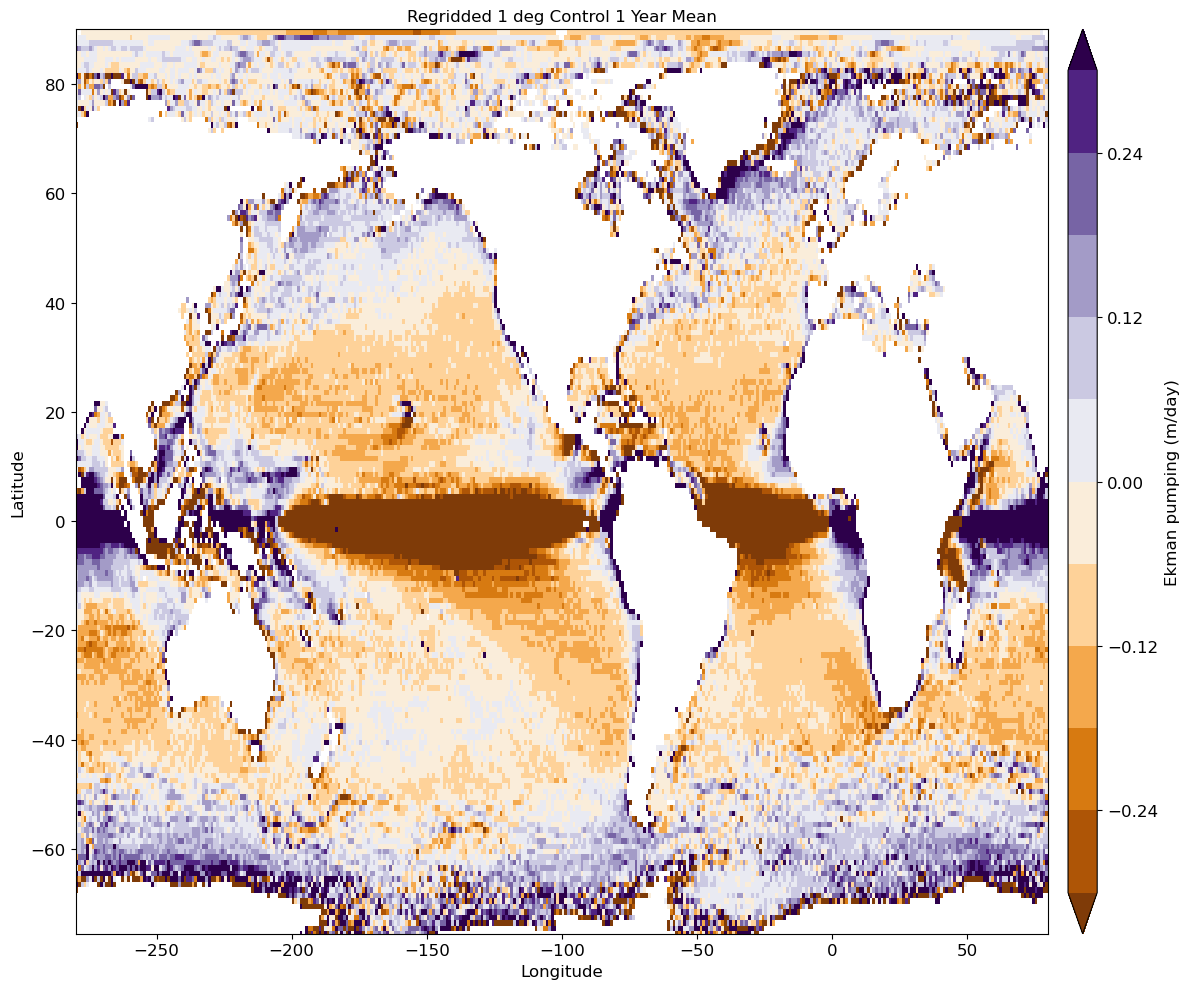

In [26]:
#ekman.mean(dim='time').plot.pcolormesh(cmap=cmocean.balance,vmin=-.3,vmax=.3)

#Compare to Figure 3 in this paper
#https://www.sciencedirect.com/science/article/pii/S1463500318303779?via%3Dihub

fontsize=12

clev = np.arange(-.30,.36,.06)

plt.figure(figsize=(12,10))

plt.subplot(1,1,1)
pc=ekman_regridded.plot.pcolormesh(x='lon', y='lat',vmin=-.30, vmax=.30, levels=clev,cmap=plt.cm.PuOr,add_colorbar=False)
plt.ylim(-75.5,90)
plt.xlim(-280,80)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.title('Regridded 1 deg Control 1 Year Mean',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

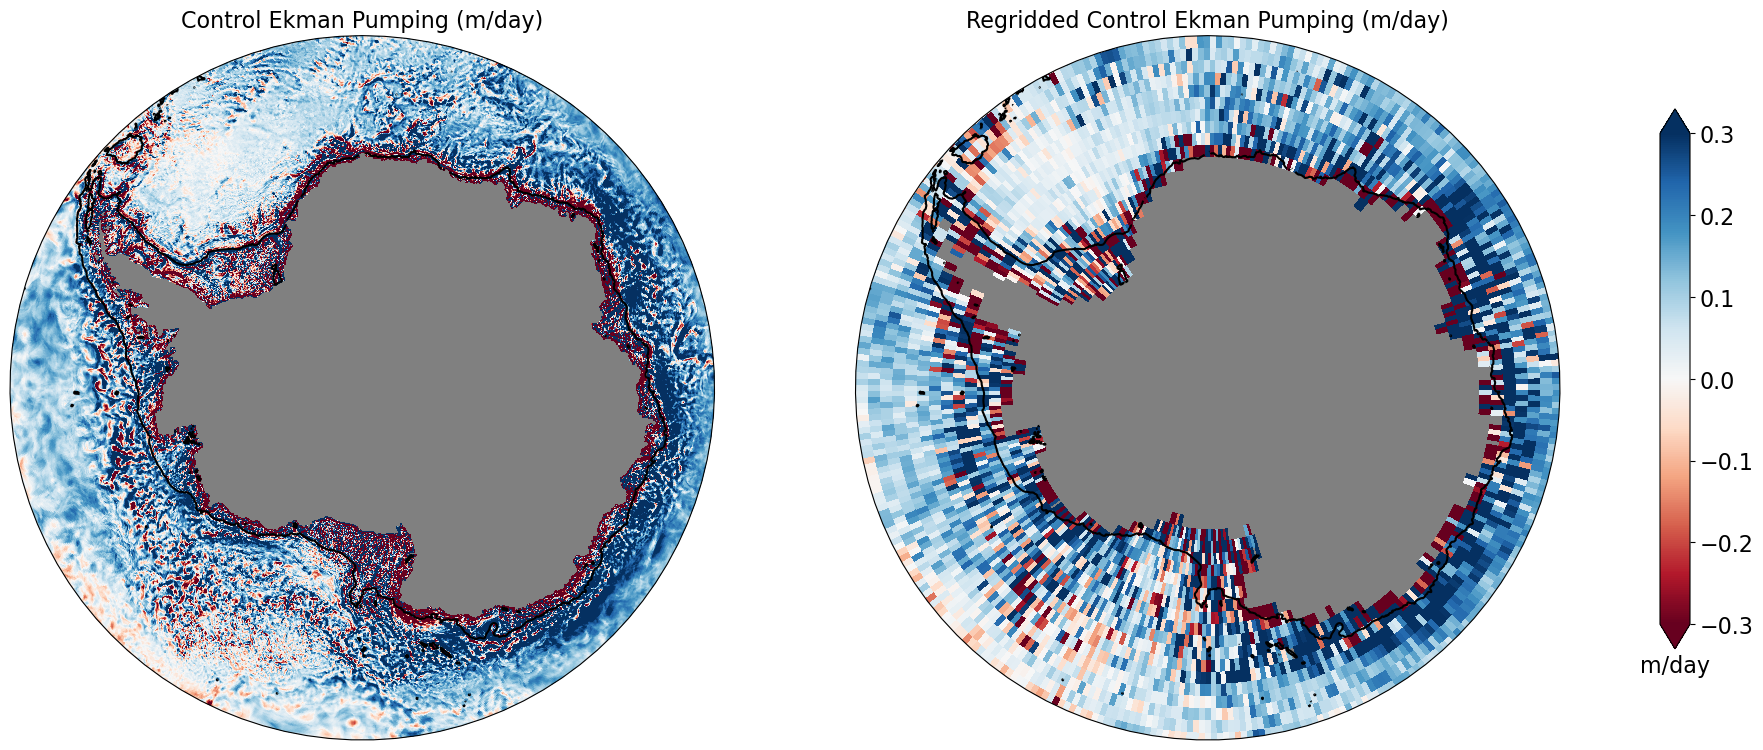

In [27]:
fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = ekman.plot.pcolormesh(x='lon', y='lat',vmin=-.3, vmax=.3, add_colorbar=False, cmap=plt.cm.RdBu, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

tit='Control Ekman Pumping (m/day)'
plt.title(tit,fontsize = 16)


ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = ekman_regridded.plot.pcolormesh(x='lon', y='lat',vmin=-.3, vmax=.3, add_colorbar=False, cmap=plt.cm.RdBu, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

tit='Regridded Control Ekman Pumping (m/day)'
plt.title(tit,fontsize = 16)

# colorbar:
#rect = [left, bottom, width, height]
ax_cb = plt.axes([.95, 0.35, 0.015, 0.3])
cb = plt.colorbar(p1,cax=ax_cb,orientation='vertical', extend='both', shrink=0.5)
cb.ax.set_xlabel('m/day',fontsize=16);
cb.ax.tick_params(labelsize=16) 
    
plt.tight_layout()

## Control Ekman pumping calc ... annual mean not accounting for differing days/month

In [20]:
end_time='2150-12-31'

tau_x = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(control, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [22]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [23]:
ekman_con = curl_tauf/rho0*s_day
# mask land:
ekman_con = ekman_con.where(ekman_con!=0)

In [24]:
# Change coords to t grid:
ekman_con['xu_ocean'] = xt_ocean.values
ekman_con['yu_ocean'] = yt_ocean.sel(yt_ocean=lat_slice).values
ekman_con = ekman_con.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [39]:
ekman_con

<xarray.DataArray (time: 1, yt_ocean: 665, xt_ocean: 3600)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.08758536,  0.12724932,  0.14300992, ..., -0.02445728,
          0.00243937,  0.05013824],
        [ 0.13902583,  0.14800565,  0.15477494, ...,  0.03091593,
          0.07811027,  0.12683452],
        [ 0.17560306,  0.16211757,  0.15371912, ...,  0.09202829,
          0.14522575,  0.18256734]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
  * time      (time) object 2150-12-31 00:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yt_ocean, xt_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06
    TLON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.09 -50.09 -50.09
    ULON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06

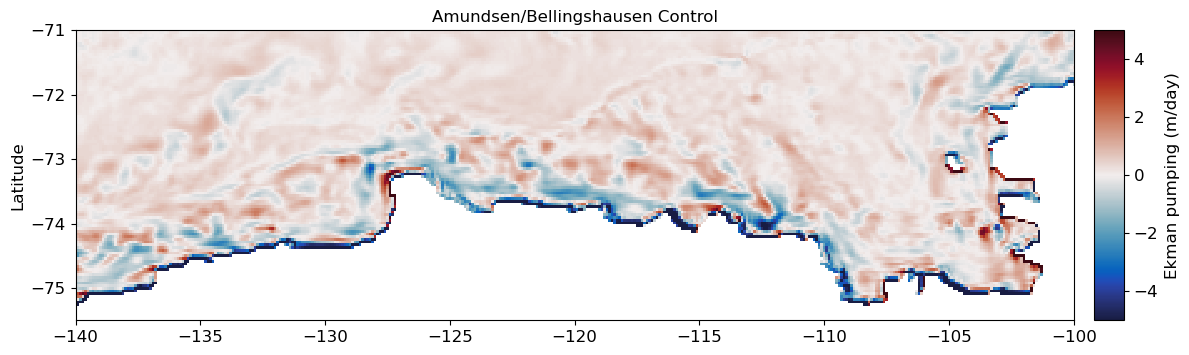

In [40]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Amundsen/Bellingshausen Control',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

## Control Ekman pumping calc ... accounting for differing days/month

In [48]:
end_time='2150-12-31'

tau_x = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(control, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [49]:
time_monthly = tau_x.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(expt,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(tau_x.time)/12, 1).astype('int')
n_years = len(time_yearly)
n_days_array.values

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

In [50]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [51]:
ekman_con = curl_tauf/rho0*s_day
# mask land:
ekman_con = ekman_con.where(ekman_con!=0)

In [52]:
# Change coords to t grid:
ekman_con['xu_ocean'] = xt_ocean.values
ekman_con['yu_ocean'] = yt_ocean.sel(yt_ocean=lat_slice).values
ekman_con = ekman_con.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [53]:
ekman_con

<xarray.DataArray (time: 12, yt_ocean: 665, xt_ocean: 3600)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.01983805,  0.08581309,  0.13094001, ..., -0.16484916,
         -0.16911664, -0.11213102],
        [-0.06114402,  0.04644187,  0.14113643, ..., -0.16029083,
         -0.16737676, -0.13012939],
        [-0.0995523 , -0.01464918,  0.10770496, ..., -0.1482886 ,
         -0.15303317, -0.13958958]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.46648513,  0.48678687,  0.51367761, ...,  0.35012524,
          0.42077597,  0.46091351],
        [ 0.4818646 ,  0.49795553,  0.50460477, ...,  0.41501599,
          0.46491584,  0.48766399],
        [ 0.49462561,  0.48737725,  0.48527043, ...,  0.43874937,
          0.46746954,  0.48733155]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.11424107,  0.07241346,  0.01630304, ...,  0.06450685,
          0.0936433 ,  0.10883726],
        [ 0.14274538,  0.06688659,  0.07877956, ...,  0.19588549,
          0.22409858,  0.21547606],
        [ 0.1361505 ,  0.10977341,  0.18681834, ...,  0.3056051 ,
          0.30162593,  0.2568083 ]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -50.22 -50.16 -50.09
  * time      (time) object 2150-01-16 12:00:00 ... 2150-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yt_ocean, xt_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06
    TLON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.09 -50.09 -50.09
    ULON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06

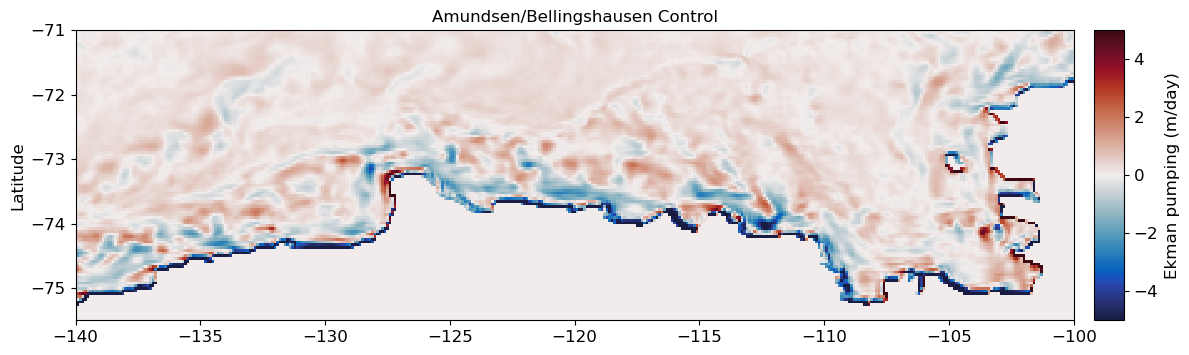

In [54]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Amundsen/Bellingshausen Control',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,(ekman_con*n_days_array).sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

## Up Ekman Pumping Calcs

In [38]:
tau_x = cc.querying.getvar(easterlies_up, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(easterlies_up, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [39]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [40]:
ekman_up = curl_tauf/rho0*s_day
# mask land:
ekman_up = ekman_up.where(ekman_up!=0)

In [41]:
# Change coords to t grid:
ekman_up['xu_ocean'] = xt_ocean.values
ekman_up['yu_ocean'] = yt_ocean.sel(yt_ocean=lat_slice).values
ekman_up = ekman_up.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

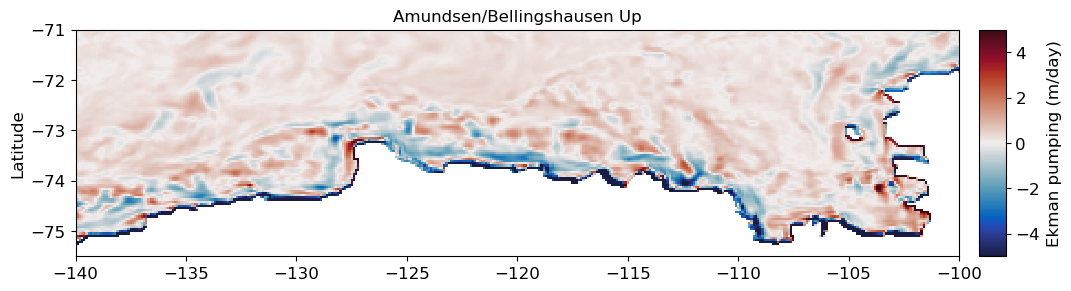

In [42]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Amundsen/Bellingshausen Up',fontsize=fontsize)
pc=plt.pcolormesh(ekman_up.xt_ocean,ekman_up.yt_ocean,ekman_up.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## Down Ekman Pumping Calcs

In [43]:
tau_x = cc.querying.getvar(easterlies_down, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(easterlies_down, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [44]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [45]:
ekman_down = curl_tauf/rho0*s_day
# mask land:
ekman_down = ekman_down.where(ekman_down!=0)

In [46]:
# Change coords to t grid:
ekman_down['xu_ocean'] = xt_ocean.values
ekman_down['yu_ocean'] = yt_ocean.sel(yt_ocean=lat_slice).values
ekman_down = ekman_down.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

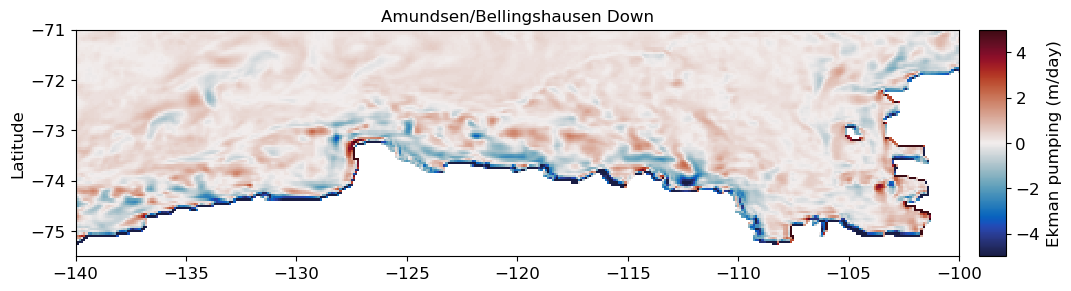

In [47]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Amundsen/Bellingshausen Down',fontsize=fontsize)
pc=plt.pcolormesh(ekman_down.xt_ocean,ekman_down.yt_ocean,ekman_down.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## UP Only Zonal Ekman Pumping Calcs


In [30]:
end_time='2164-12-31'
expt='01deg_jra55v13_ryf9091_easterlies_up10_zonal'

tau_x = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(expt, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [31]:
tau_x

<xarray.DataArray 'tau_x' (time: 8, yu_ocean: 665, xu_ocean: 3600)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.20082645, 0.20187248, 0.2027895 , ..., 0.19818366,
         0.19890587, 0.19980891],
        [0.20135702, 0.20225894, 0.20295636, ..., 0.1985793 ,
         0.19939424, 0.20036007],
        [0.20193212, 0.2026676 , 0.20311053, ..., 0.19902004,
         0.19999345, 0.20101924]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.20037627, 0.20034243, 0.20036216, ..., 0.19952314,
         0.2000348 , 0.20033479],
        [0.20177327, 0.2016173 , 0.20144355, ..., 0.20068045,
         0.20122154, 0.2016484 ],
        [0.20334251, 0.20317687, 0.20283647, ..., 0.20228255,
         0.20283987, 0.20322223]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.15913267, 0.16071673, 0.16234384, ..., 0.1541566 ,
         0.15572888, 0.15745135],
        [0.16002253, 0.161511  , 0.16304274, ..., 0.15537868,
         0.15683408, 0.15847342],
        [0.16106771, 0.16245365, 0.16385055, ..., 0.15709831,
         0.15840153, 0.15974508]]], dtype=float32)
Coordinates:
  * time      (time) object 2150-12-31 00:00:00 ... 2157-12-31 00:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -50.19 -50.12 -50.06

In [32]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [33]:
ekman_upz = curl_tauf/rho0*s_day
# mask land:
ekman_upz = ekman_upz.where(ekman_upz!=0)

In [34]:
# Change coords to t grid:
ekman_upz['xu_ocean'] = xt_ocean.values
ekman_upz['yu_ocean'] = yt_ocean.sel(yt_ocean=lat_slice).values
ekman_upz = ekman_upz.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

## Up Only Meridional Ekman Pumping Calcs


In [35]:
end_time='2164-12-31'
expt='01deg_jra55v13_ryf9091_easterlies_up10_meridional'

tau_x = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(expt, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [36]:
tau_x

<xarray.DataArray 'tau_x' (time: 7, yu_ocean: 665, xu_ocean: 3600)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.20100375, 0.20266628, 0.20397447, ..., 0.19604719,
         0.19747414, 0.19917099],
        [0.20177658, 0.20332925, 0.2046114 , ..., 0.19682436,
         0.1983289 , 0.20005727],
        [0.20270628, 0.20407057, 0.20513779, ..., 0.19794102,
         0.19946915, 0.20115262]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.19968446, 0.2002663 , 0.20081247, ..., 0.19717312,
         0.19803213, 0.19894387],
        [0.20086952, 0.20130609, 0.20166884, ..., 0.19852261,
         0.1993276 , 0.20017569],
        [0.20213568, 0.2025377 , 0.20294817, ..., 0.20011955,
         0.20087433, 0.20156966]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.19892742, 0.1996689 , 0.20033331, ..., 0.1967466 ,
         0.19747345, 0.1981694 ],
        [0.2008884 , 0.20148118, 0.20206434, ..., 0.19855238,
         0.19940722, 0.20019364],
        [0.2029521 , 0.20338655, 0.2038181 , ..., 0.20061219,
         0.20145972, 0.20228009]]], dtype=float32)
Coordinates:
  * time      (time) object 2150-12-31 00:00:00 ... 2156-12-31 00:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -50.19 -50.12 -50.06

In [37]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [38]:
ekman_upm = curl_tauf/rho0*s_day
# mask land:
ekman_upm = ekman_upm.where(ekman_upm!=0)

In [39]:
# Change coords to t grid:
ekman_upm['xu_ocean'] = xt_ocean.values
ekman_upm['yu_ocean'] = yt_ocean.sel(yt_ocean=lat_slice).values
ekman_upm = ekman_upm.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

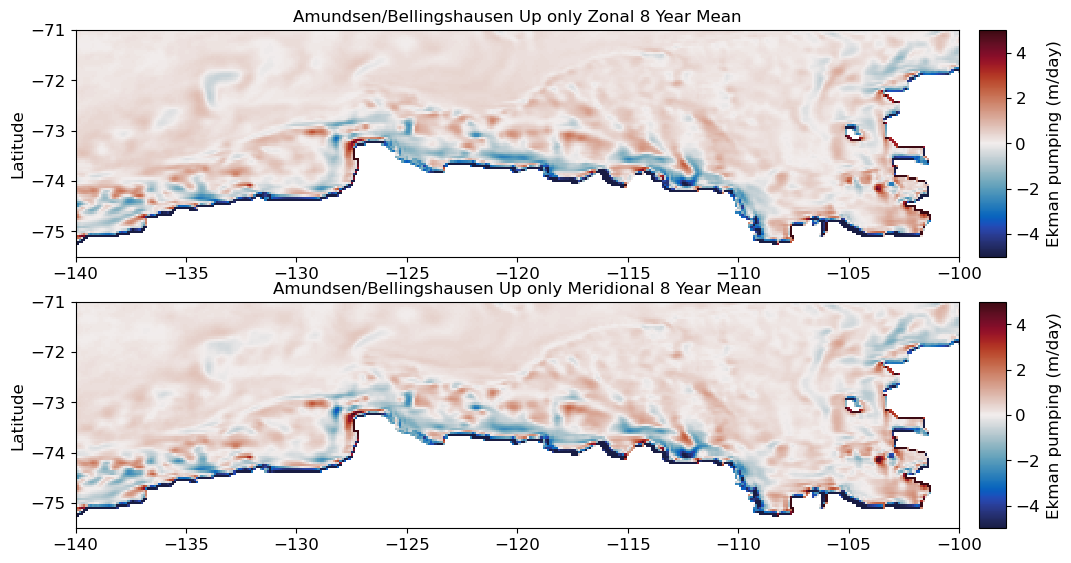

In [40]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Amundsen/Bellingshausen Up only Zonal 8 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_upz.xt_ocean,ekman_upz.yt_ocean,ekman_upz.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('Amundsen/Bellingshausen Up only Meridional 8 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_upm.xt_ocean,ekman_upm.yt_ocean,ekman_upm.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

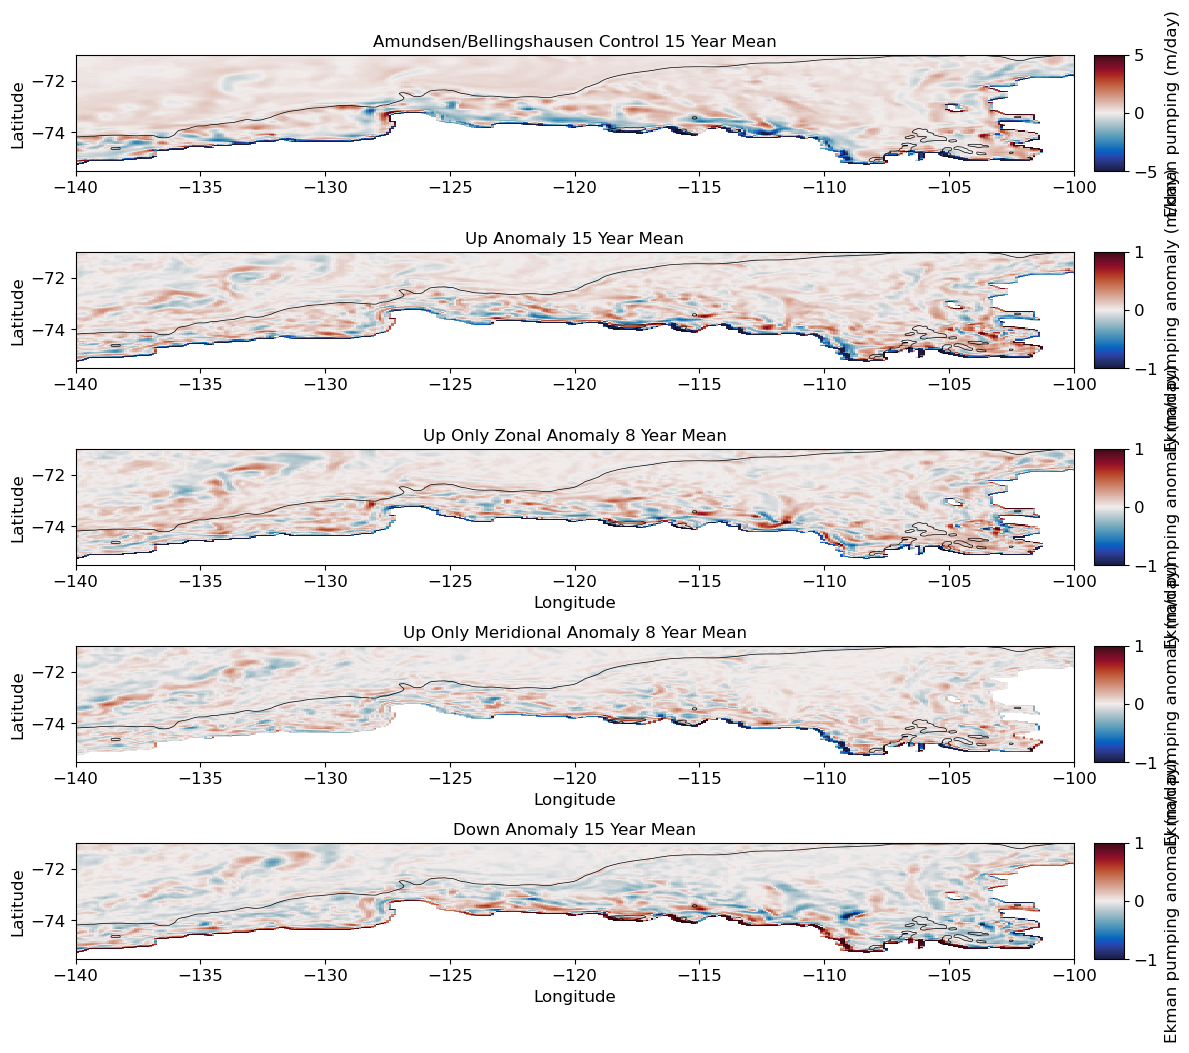

In [43]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(5,1,1)
plt.title('Amundsen/Bellingshausen Control 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(5,1,2)
plt.title('Up Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_up.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(5,1,3)
plt.title('Up Only Zonal Anomaly 8 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_upz.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(5,1,4)
plt.title('Up Only Meridional Anomaly 8 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_upm.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(5,1,5)
plt.title('Down Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_down.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


# Time-series of integrated Ekman pumping on the shelf and coast

In [45]:
#mask shelf regions
cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(yt_ocean>-63)))
cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')

cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_con_coast=(ekman_con*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_coast=(ekman_up*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_coast=(ekman_down*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [46]:
#integrate up Ekman pumping on the shelf
#mask shelf regions
shmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
shmask = shmask.where(~xr.ufuncs.isfinite(shmask.where(yt_ocean>-63)))
shmask = ~xr.ufuncs.isnan(shmask).to_dataset(name='shmask')

sharea=area_t.where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_con_shelf=(ekman_con*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf=(ekman_up*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf=(ekman_down*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [46]:
#print(cstarea, ekman_con_coast,ekman_up_coast,ekman_down_coast)
#print(sharea, ekman_con_shelf,ekman_up_shelf,ekman_down_shelf)


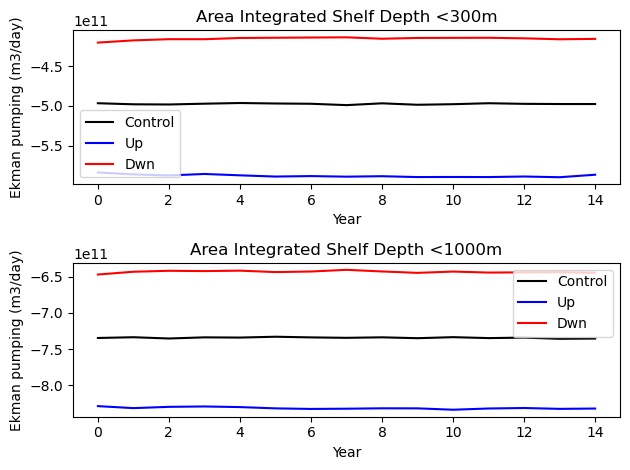

In [47]:
yrs=np.arange(0,15,1)

plt.subplot(211)
plt.plot(yrs,ekman_con_coast,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(yrs,ekman_up_coast,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(yrs,ekman_down_coast,linestyle='-',color='r',label='Dwn',linewidth=1.5)
#plt.plot(yrs,siv_up_shelf,linestyle='-',color='r',label='Up',linewidth=1.5)
#plt.plot(yrs,siv_dwn_shelf,linestyle='-',color='b',label='Down',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Ekman pumping (m3/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
plt.title('Area Integrated Shelf Depth <300m')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(yrs,ekman_con_shelf,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(yrs,ekman_up_shelf,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(yrs,ekman_down_shelf,linestyle='-',color='r',label='Dwn',linewidth=1.5)
#plt.plot(yrs,siv_up_shelf,linestyle='-',color='r',label='Up',linewidth=1.5)
#plt.plot(yrs,siv_dwn_shelf,linestyle='-',color='b',label='Down',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Ekman pumping (m3/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
plt.title('Area Integrated Shelf Depth <1000m')
plt.legend(fontsize=10)

plt.tight_layout()

# time-series of area average Ekman Pumping

In [47]:
ekman_con_coast_avg=ekman_con.where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_coast_avg=ekman_up.where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_coast_avg=ekman_down.where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_coast_avg=ekman_upz.where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_coast_avg=ekman_upm.where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()

ekman_con_shelf_avg=ekman_con.where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf_avg=ekman_up.where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf_avg=ekman_down.where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_shelf_avg=ekman_upz.where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_shelf_avg=ekman_upm.where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()



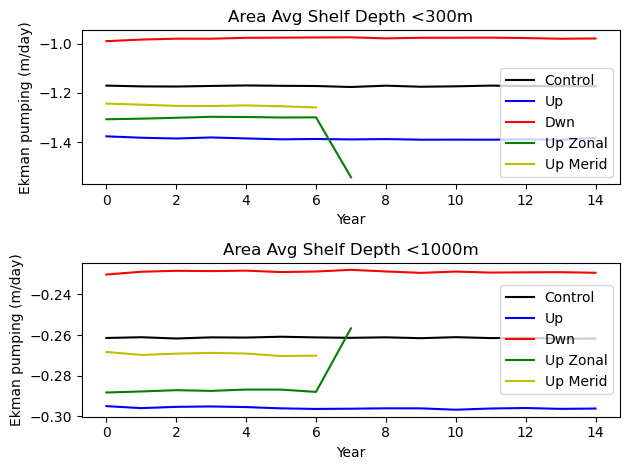

In [49]:
yrs=np.arange(0,15,1)

plt.subplot(211)
plt.plot(yrs,ekman_con_coast_avg,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(yrs,ekman_up_coast_avg,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(yrs,ekman_down_coast_avg,linestyle='-',color='r',label='Dwn',linewidth=1.5)
plt.plot(yrs[0:8],ekman_upz_coast_avg,linestyle='-',color='g',label='Up Zonal',linewidth=1.5)
plt.plot(yrs[0:7],ekman_upm_coast_avg,linestyle='-',color='y',label='Up Merid',linewidth=1.5)
#plt.plot(yrs,siv_up_shelf,linestyle='-',color='r',label='Up',linewidth=1.5)
#plt.plot(yrs,siv_dwn_shelf,linestyle='-',color='b',label='Down',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Ekman pumping (m/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
plt.title('Area Avg Shelf Depth <300m')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(yrs,ekman_con_shelf_avg,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(yrs,ekman_up_shelf_avg,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(yrs,ekman_down_shelf_avg,linestyle='-',color='r',label='Dwn',linewidth=1.5)
plt.plot(yrs[0:8],ekman_upz_shelf_avg,linestyle='-',color='g',label='Up Zonal',linewidth=1.5)
plt.plot(yrs[0:7],ekman_upm_shelf_avg,linestyle='-',color='y',label='Up Merid',linewidth=1.5)
#plt.plot(yrs,siv_up_shelf,linestyle='-',color='r',label='Up',linewidth=1.5)
#plt.plot(yrs,siv_dwn_shelf,linestyle='-',color='b',label='Down',linewidth=1.5)
#plt.ylim((1037.5,1035))
plt.ylabel('Ekman pumping (m/day)')
plt.xlabel('Year')
#plt.xlim([-75,85])
plt.title('Area Avg Shelf Depth <1000m')
plt.legend(fontsize=10)

plt.tight_layout()

# Plot other regions close-ups

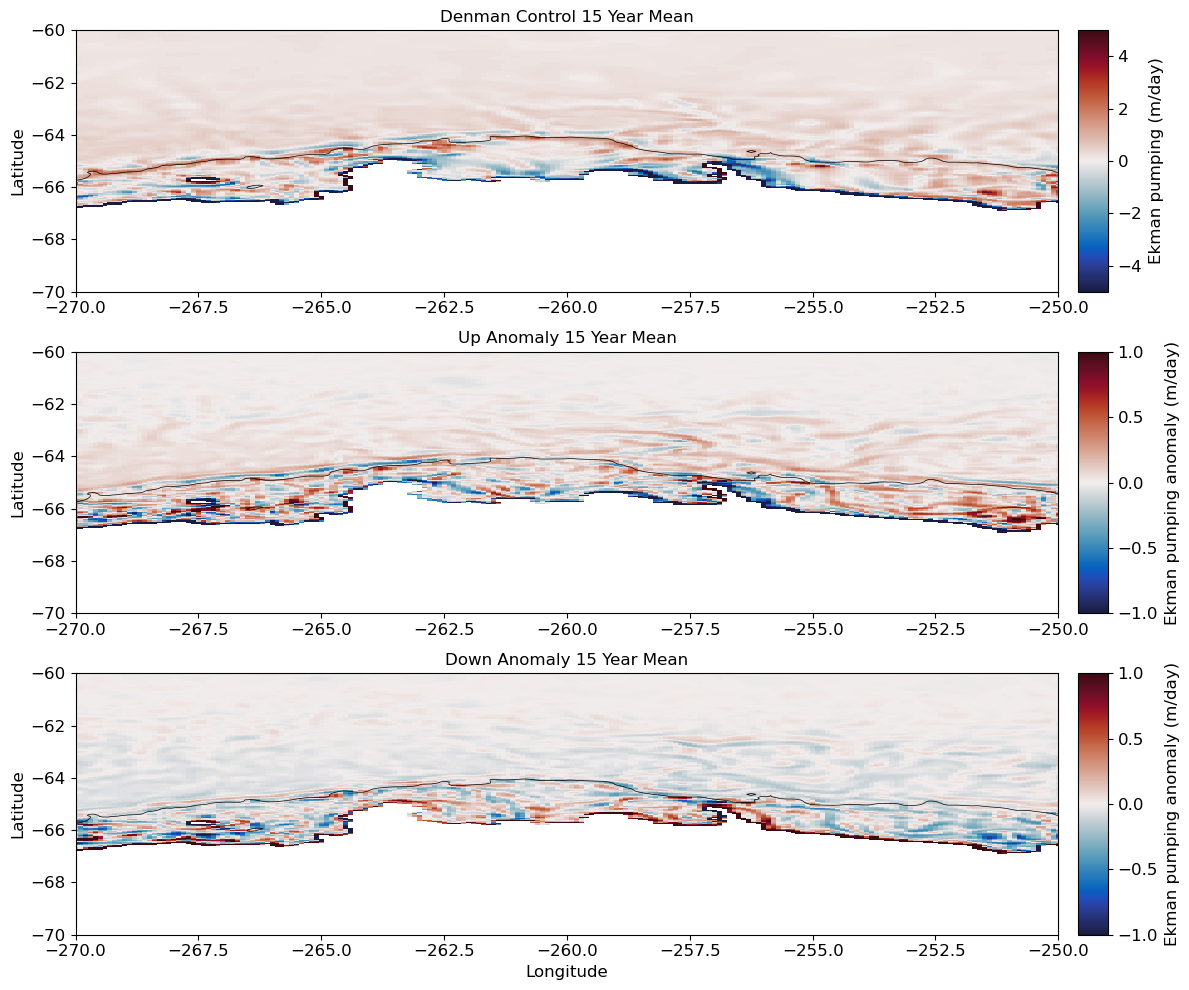

In [55]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Denman Control 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim([-70,-60])
plt.xlim([-270,-250])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('Up Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_up.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-70,-60])
plt.xlim([-270,-250])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
plt.title('Down Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_down.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-70,-60])
plt.xlim([-270,-250])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


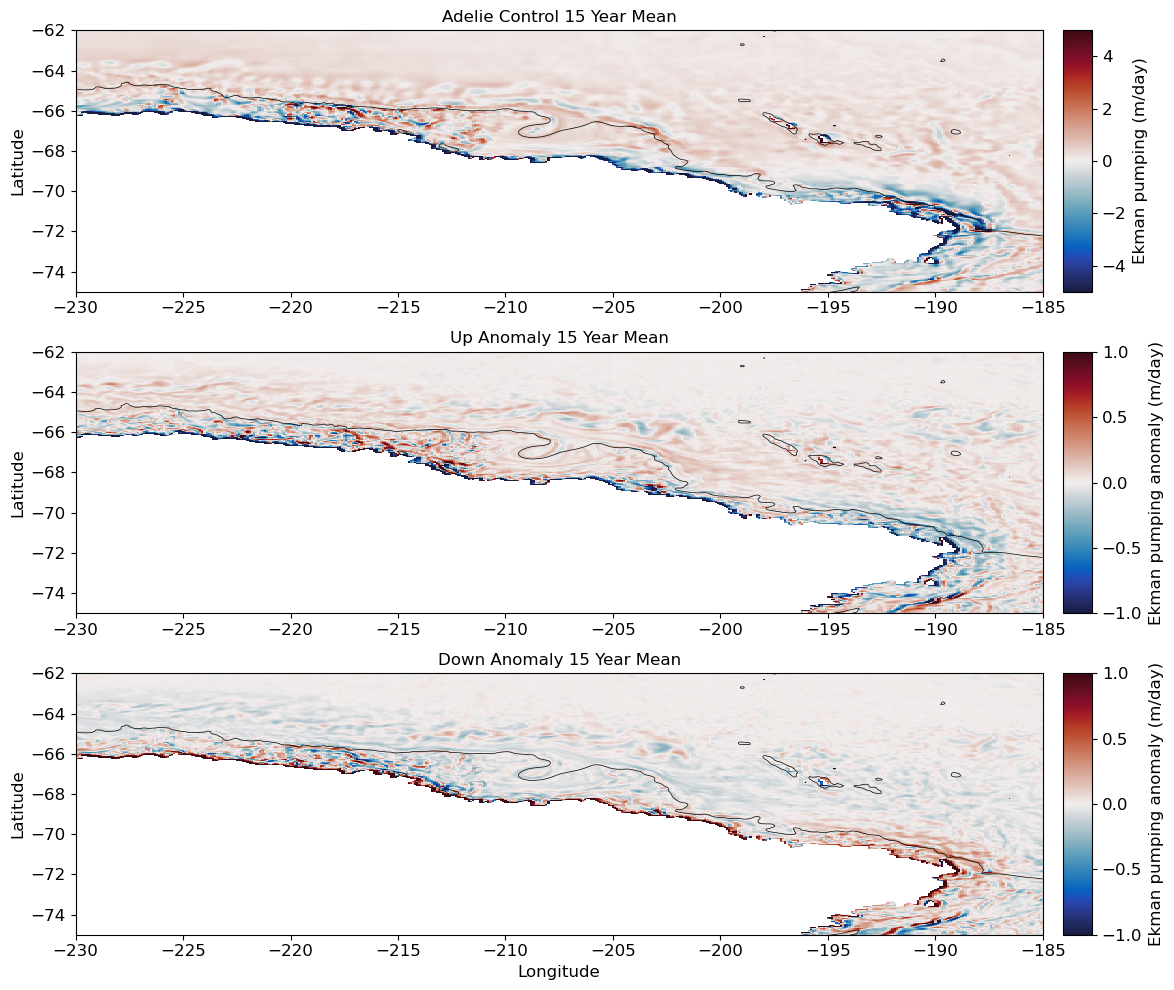

In [56]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Adelie Control 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim([-75,-62])
plt.xlim([-230,-185])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('Up Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_up.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-75,-62])
plt.xlim([-230,-185])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
plt.title('Down Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_down.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-75,-62])
plt.xlim([-230,-185])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


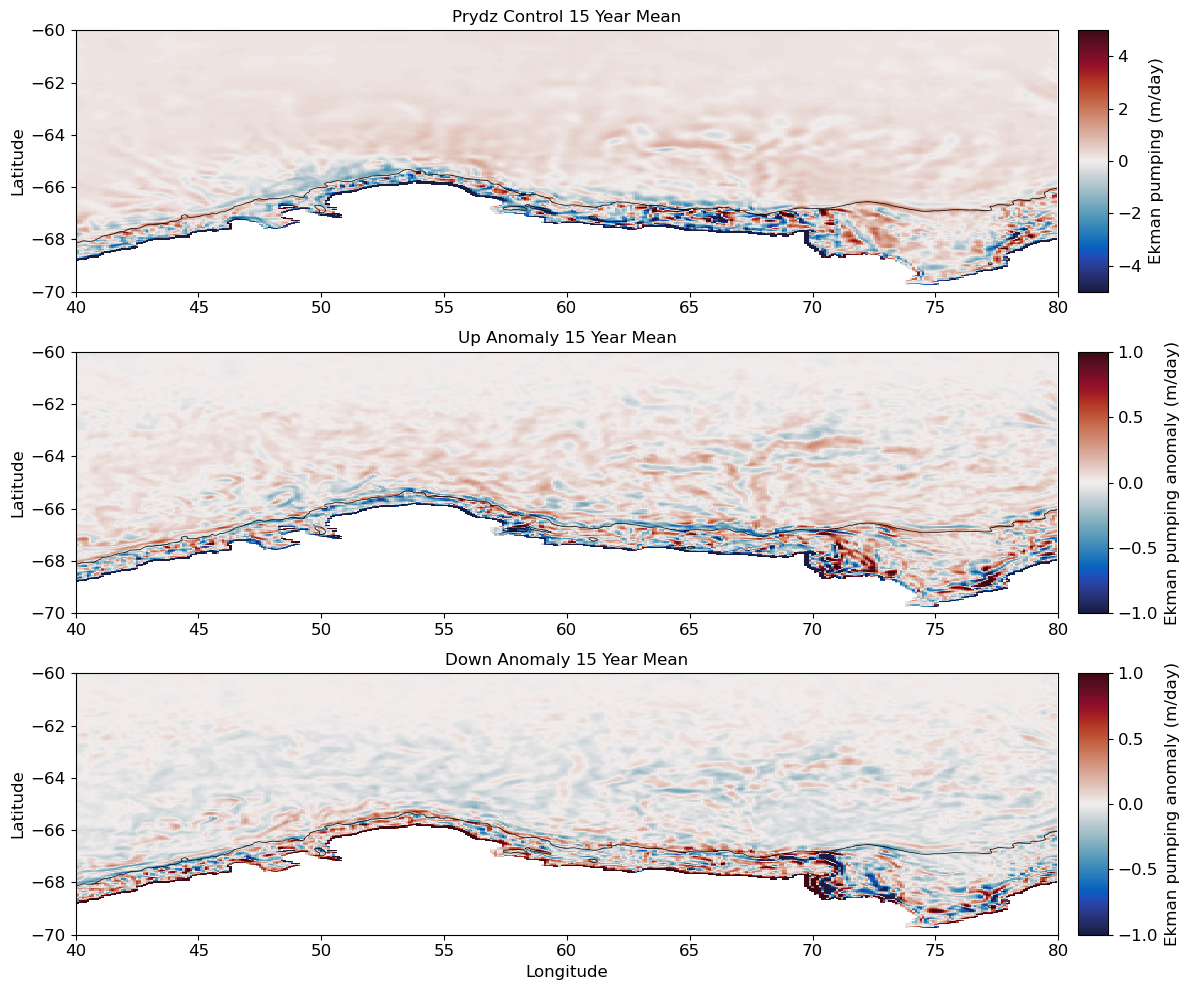

In [57]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Prydz Control 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim([-70,-60])
plt.xlim([40,80])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('Up Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_up.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-70,-60])
plt.xlim([40,80])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
plt.title('Down Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_down.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-70,-60])
plt.xlim([40,80])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


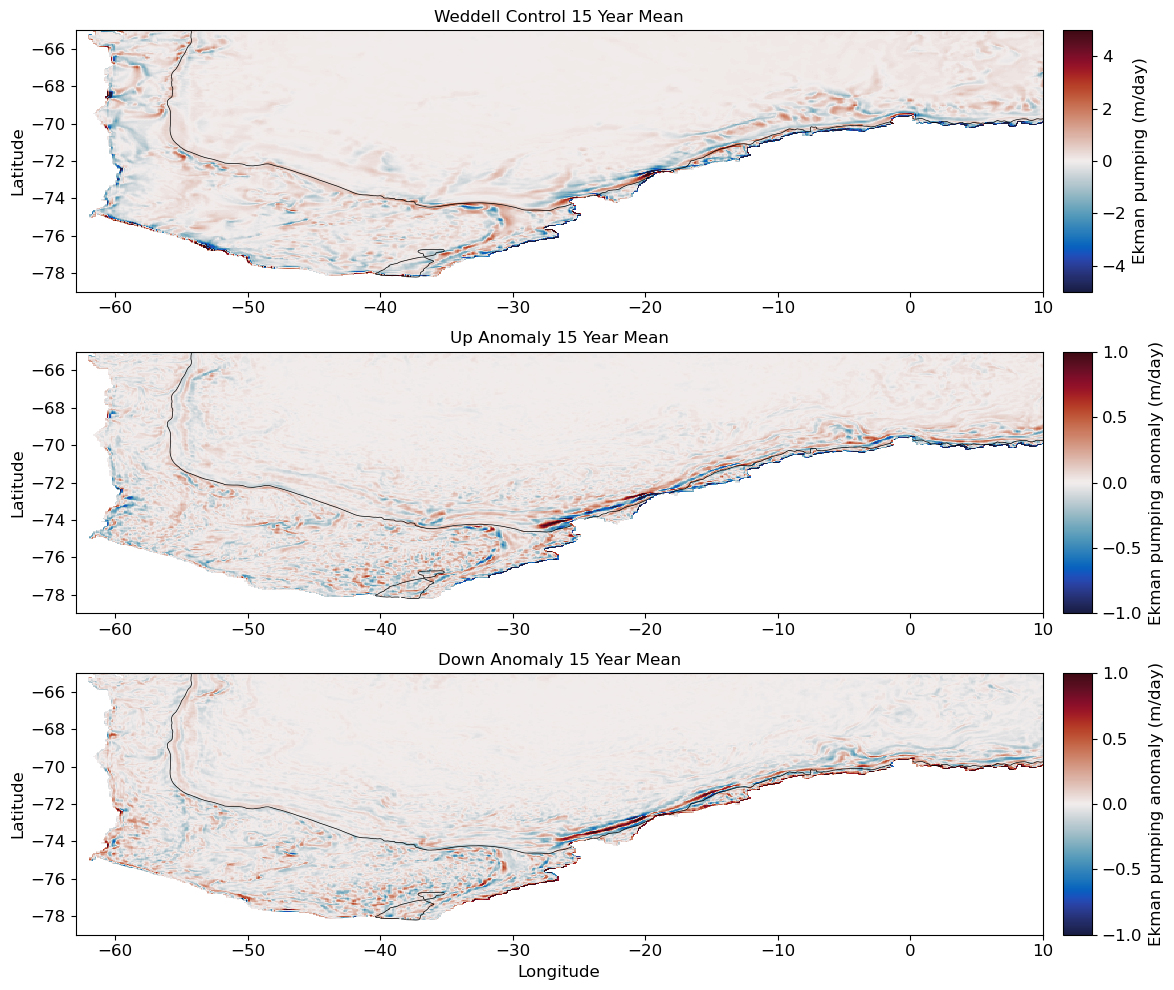

In [58]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
plt.title('Weddell Control 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-5,vmax=5)
plt.ylim([-79,-65])
plt.xlim([-63,10])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('Up Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_up.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-79,-65])
plt.xlim([-63,10])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
plt.title('Down Anomaly 15 Year Mean',fontsize=fontsize)
pc=plt.pcolormesh(ekman_con.xt_ocean,ekman_con.yt_ocean,ekman_down.mean(dim='time')-ekman_con.mean(dim='time'),cmap=cmocean.balance,vmin=-1,vmax=1)
plt.ylim([-79,-65])
plt.xlim([-63,10])
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping anomaly (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

#figure_path = figdir+'/Ekman_pumping_Amundsen_zoom_yrs_2050_2164.png'
#plt.savefig(figure_path, dpi=250,bbox_inches='tight', pad_inches=0.1,facecolor='white')


In [59]:
#Ekman pumping calc ... method 3
#Errror here on ocean grid cell next to land - due to nans dxt/dyt on land 
#https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb

folder = '/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output001/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

ds_con = xr.merge([taux_con, tauy_con, grid])
ds_con.coords['xt_ocean'].attrs.update(axis='X')
ds_con.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_con.coords['yt_ocean'].attrs.update(axis='Y')
ds_con.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_con = xgcm.Grid(ds_con, periodic=['X'])

rho0=1034
we_con_xgcm = ( grid_con.interp( grid_con.diff(ds_con.tau_y/f, 'X') / grid_con.interp(ds_con.dxu, 'X'), 'Y', boundary='extend')
          - grid_con.interp( grid_con.diff(ds_con.tau_x/f, 'Y', boundary='extend') / grid_con.interp(ds_con.dyt, 'X'), 'X') )/rho0

#convert from m/s to m/day
s_day=60*60*24
we_con_xgcm=we_con_xgcm*s_day

we_con_xgcm = we_con_xgcm.rename('Ekman Pumping')
we_con_xgcm.attrs['long_name'] = 'Ekman Pumping, (d(Tau_y/f) /dx - d(Tau_x/f) / dy) /rho_0'
we_con_xgcm.attrs['units'] = 'm/day'

NameError: name 'taux_con' is not defined

In [16]:
ds_up = xr.merge([taux_up, tauy_up, grid])
ds_up.coords['xt_ocean'].attrs.update(axis='X')
ds_up.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_up.coords['yt_ocean'].attrs.update(axis='Y')
ds_up.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_up = xgcm.Grid(ds_up, periodic=['X'])

rho0=1034
we_up_xgcm = ( grid_up.interp( grid_up.diff(ds_up.tau_y/f, 'X') / grid_up.interp(ds_up.dxu, 'X'), 'Y', boundary='extend')
          - grid_up.interp( grid_up.diff(ds_up.tau_x/f, 'Y', boundary='extend') / grid_up.interp(ds_up.dyt, 'X'), 'X') )/rho0

#convert from m/s to m/day
s_day=60*60*24
we_up_xgcm=we_up_xgcm*s_day

we_up_xgcm = we_up_xgcm.rename('Ekman Pumping')
we_up_xgcm.attrs['long_name'] = 'Ekman Pumping, (d(Tau_y/f) /dx - d(Tau_x/f) / dy) /rho_0'
we_up_xgcm.attrs['units'] = 'm/day'

In [16]:
ds_dwn = xr.merge([taux_dwn, tauy_dwn, grid])
ds_dwn.coords['xt_ocean'].attrs.update(axis='X')
ds_dwn.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_dwn.coords['yt_ocean'].attrs.update(axis='Y')
ds_dwn.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_dwn = xgcm.Grid(ds_dwn, periodic=['X'])

rho0=1034
we_dwn_xgcm = ( grid_dwn.interp( grid_dwn.diff(ds_dwn.tau_y/f, 'X') / grid_dwn.interp(ds_dwn.dxu, 'X'), 'Y', boundary='extend')
          - grid_dwn.interp( grid_dwn.diff(ds_dwn.tau_x/f, 'Y', boundary='extend') / grid_dwn.interp(ds_dwn.dyt, 'X'), 'X') )/rho0

#convert from m/s to m/day
s_day=60*60*24
we_dwn_xgcm=we_dwn_xgcm*s_day

we_dwn_xgcm = we_dwn_xgcm.rename('Ekman Pumping')
we_dwn_xgcm.attrs['long_name'] = 'Ekman Pumping, (d(Tau_y/f) /dx - d(Tau_x/f) / dy) /rho_0'
we_dwn_xgcm.attrs['units'] = 'm/day'